In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import multiprocessing
import matplotlib.pyplot as plt

data process(Binary)

In [2]:
class data_proc():
    
    def process_zip():
        #dealing with zipcode
        zip_data=pd.read_csv('ZIP.csv')
        zip_data['Zip']=zip_data['Zip'].astype(str)
        for i in range(len(zip_data['Zip'])):
            if len(zip_data['Zip'][i])==4:
                zip_data['Zip'][i]='0'+zip_data['Zip'][i]
        zip_data['Zip']=[zip_data['Zip'][i][0:3] for i in range(len(zip_data))] 
        zip_data.iloc[:,-3:]=zip_data[['Median','Mean','Pop']].apply(lambda x: x.str.replace(',',''))
        for i in range(1,4):
            zip_data.iloc[:,-i]=pd.to_numeric(zip_data.iloc[:,-i],errors='coerce')
        zip_data['weight']=zip_data['Pop']/zip_data.groupby('Zip')['Pop'].transform(sum)
        zip_data['new_mean']=zip_data['Mean']*zip_data['weight']
        zip_data['new_median']=zip_data['Median']*zip_data['weight']
        zip_new=pd.DataFrame()
        zip_new=zip_data.groupby('Zip')['new_mean','new_median'].sum()
        return zip_new
        
    def readcsv():
        LARGE_FILE = "loan_data_no_current_converted.csv"
        CHUNKSIZE = 100000 # processing 100,000 rows at a time
        reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False)
        frames = []
        for df in reader:
            frames.append(df)
        loan_data = pd.concat(frames)
        return loan_data   
    def cleaning(df,zip_new,keep_desc=True,categorical_to_binary=True):
        df=df.dropna(axis=0,how='all')
        drop_list=['installment','term','emp_title','title','earliest_cr_line','desc','issue_d','id','member_id','url','grade','sub_grade',
                   'int_rate','avg_cur_bal','addr_state','funded_amnt','funded_amnt_inv','collection_recovery_fee',
                   'collections_12_mths_ex_med','mths_since_last_major_derog','next_pymnt_d','recoveries','total_pymnt',
                   'total_pymnt_inv','total_rec_int','issue_d',' last_credit_pull_d','last_pymnt_d','last_credit_pull_d',
                  'total_rec_prncp','settlement_status','hardship_loan_status','hardship_status','debt_settlement_flag',
                   'verification_status','total_rec_late_fee']
        df.drop(drop_list,inplace=True,axis=1,errors='ignore')
        #deal with percentage mark
        df['revol_util']=df['revol_util'].replace('%','',regex=True).astype('float')/100
        #merge zipcode with census data
        df['zip_code']=df['zip_code'].apply(lambda x: x[:3])
        df=df.join(zip_new,on='zip_code')
        df.drop('zip_code',inplace=True,axis=1)
        #drop the observation that was missing for ALL field
        df=df.dropna(axis=0,how='all')
        #drop the features for which greater than 10% of the loans were missing data for
        num_rows=df.count(axis=0)
        df=df.iloc[:,(num_rows>=0.9*len(df)).tolist()]
        #drop the observation that was missing for any field
        df=df.dropna(axis=0,how='any')
        #label the dataset to create y
        #0:fully paid, does not meet policy:fully paid
        #1:Does not meet the credit policy. Status:Charged Off",default,charge of
        df=df[(True-df['loan_status'].isin([4]))] 
        df=df[(True-df['loan_status'].isin([5]))]
        df=df[(True-df['loan_status'].isin([6]))] 
        #label the dataset to create y
        y=df['loan_status'].replace(1,0)
        y=y.replace(2,0)
        y=y.replace(3,1)
        y=y.replace(7,1)
        y=y.replace(8,1)
        df=df.drop(['loan_status'],axis=1) 
        return df,y

Run data_proc class to get Binary dataset

In [3]:
zipdata = data_proc.process_zip()
df = data_proc.readcsv()
x,y = data_proc.cleaning(df,zipdata,keep_desc=False,categorical_to_binary=True)

C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '-' operator is not supported by numexpr for the bool dtype, use '^' instead
  unsupported[op_str]))


Binary Logistic Regression(Ridge) 

In [4]:
#%% Binary logistic regression
class log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1)
        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def ModelValuation(x_test,y_test,model):
        
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        plt.figure(1)
        plt.plot(fpr, tpr, label='LogisticRegression')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
        return None  
    
    def y_pred(x_test,threshold=0.5):
        
        if threshold == 0.5:
            y_predicted = model.predict(x_test)
        else:
            probs = model.predict_proba(x_test)
            y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
        return y_predicted    
    
    def GetScores(y_test,y_predicted):
        #G means score 
        CM = metrics.confusion_matrix(y_test, y_predicted)
        TN = CM[0,0]
        FN = CM[1,0]
        TP = CM[1,1]
        FP = CM[0,1]
        
        sensitivity = float(TP)/float(TP+FN)
        specificity = float(TN)/float(TN+FP)
        G = np.sqrt(sensitivity*specificity)
        print("G score is %f" % G)
        print("Specificity is %f" % specificity)
        
        # Generate and display different evaluation metrics
        print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
        print("Confusion Marix")
        print(CM)
        
        return specificity , G
        
    # Convenience function to plot confusion matrix
    def confusion(y_test,y_predicted,title):
        
        # Define names for the three Iris types
        names = ['Default', 'Not Default']
    
        # Make a 2D histogram from the test and result arrays
        pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
        # For simplicity we create a new DataFrame
        pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
        # Display heatmap and add decorations
        hm = sns.heatmap(pd_pts, annot=True, fmt="d")
        hm.axes.set_title(title)
        
        return None
            
    def find_threshold(x_test,y_test):
    
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        sensitivity = tpr
        specificity = 1 - fpr
        G = np.sqrt(sensitivity*specificity)
        
        plt.figure(2)
        plt.plot(thresholds,G)
        plt.xlabel('Thresholds')
        plt.ylabel('G-Scores')
        plt.title('G-Scores with different thresholds')
        plt.show()
        
        
        print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
        return thresholds[np.argmax(G)]
    # this is just testing, we add weight so we don't need to adjust threshold

Run Binary logistic Regression(Ridge)

C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

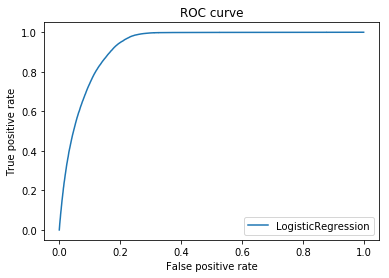

Area Under the Curve (AUC) from prediction score is 0.931268
G score is 0.868532
Specificity is 0.781124
Mean accuracy score is 0.820295
Confusion Marix
[[118780  33283]
 [  1404  39555]]


In [5]:
# Split
x_train, x_test, y_train, y_test = log_reg.split(x,y,rand=None)
# Normalize
not_bi = log_reg.not_bi(x)
scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = log_reg.reg(x_train_scaled,y_train)
# Evaluate model
log_reg.ModelValuation(x_test_scaled,y_test,model)
y_predicted = log_reg.y_pred(x_test_scaled,threshold=0.5)
spec , G = log_reg.GetScores(y_test,y_predicted)
log_reg.confusion(y_test,y_predicted,'Default Confusion Matrix')

Check the mean accuracy score for every class

In [6]:
y_predicted = model.predict(x_test)
cnt_0=0
cnt_0_predicted=0
cnt_1=0
cnt_1_predicted=0
for x in range(len(y_predicted)):
    if y_test[x]==0:
        cnt_0+=1
    if y_test[x]==0 and y_predicted[x]==0:
        cnt_0_predicted+=1 
    if y_test[x]==1:
        cnt_1+=1
    if y_test[x]==1 and y_predicted[x]==1:
        cnt_1_predicted+=1 
print("mean accuracy for fully paid", cnt_0_predicted/cnt_0)
print("mean accuracy for Default", cnt_1_predicted/cnt_1)

mean accuracy for fully paid 0.7811236132392495
mean accuracy for Default 0.965721819380356


In [23]:
features=[]
for key, value in x_train_scaled.iteritems():
    features.append(key)
features


['loan_amnt',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'last_pymnt_amnt',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_cre

In [43]:
coefficient=[]
feature_coef=model.coef_
for x in feature_coef:
    for y in x:
        coefficient.append(y)
weight=zip(features,coefficient)



In [46]:
weight=tuple(weight)
print (sorted(weight, key=lambda t: (-t[1], t[0])))

[('loan_amnt', 0.95128207471162107), ('total_bal_ex_mort', 0.31977614766316848), ('dti', 0.30717652410352736), ('acc_open_past_24mths', 0.29148903268001325), ('initial_list_status', 0.18680750146172492), ('percent_bc_gt_75', 0.17789617533049809), ('num_bc_sats', 0.14808388800458697), ('num_tl_op_past_12m', 0.13656290472004876), ('delinq_2yrs', 0.11828028469510475), ('purpose', 0.11608631189702585), ('hardship_reason', 0.085809991017707532), ('out_prncp_inv', 0.084186082907108634), ('out_prncp', 0.084170587716691322), ('inq_last_6mths', 0.081806312064737235), ('pub_rec', 0.073011994469276267), ('new_median', 0.061688258054992444), ('num_accts_ever_120_pd', 0.057616095514475996), ('revol_util', 0.056659509355668151), ('tot_cur_bal', 0.054363828404613027), ('disbursement_method', 0.036536101520646382), ('application_type', 0.026227242926594539), ('num_rev_tl_bal_gt_0', 0.024169700076661131), ('acc_now_delinq', 0.022626302516030965), ('pub_rec_bankruptcies', 0.01936261552115531), ('mo_sin_

In [48]:
print(sorted(weight, key=lambda t: (-t[1], t[0]))[:10])

[('loan_amnt', 0.95128207471162107), ('total_bal_ex_mort', 0.31977614766316848), ('dti', 0.30717652410352736), ('acc_open_past_24mths', 0.29148903268001325), ('initial_list_status', 0.18680750146172492), ('percent_bc_gt_75', 0.17789617533049809), ('num_bc_sats', 0.14808388800458697), ('num_tl_op_past_12m', 0.13656290472004876), ('delinq_2yrs', 0.11828028469510475), ('purpose', 0.11608631189702585)]


In [8]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
tpot.fit(x_train_scaled, y_train)
print(tpot.score(x_test_scaled, y_test))
tpot.export('tpot_boston_pipeline.py')

Generation 1 - Current best internal CV score: -0.083838768565413


Generation 2 - Current best internal CV score: -0.08064426478439243


Generation 3 - Current best internal CV score: -0.08064426478439243


Generation 4 - Current best internal CV score: -0.07324939153201887


Generation 5 - Current best internal CV score: -0.07324939153201887



Best pipeline: DecisionTreeRegressor(DecisionTreeRegressor(RidgeCV(input_matrix), max_depth=3, min_samples_leaf=18, min_samples_split=3), max_depth=7, min_samples_leaf=7, min_samples_split=2)
-0.0734595202825


True

In [9]:
tpot_pred = tpot.predict(x_test_scaled)
sub1 = pd.DataFrame(data=tpot_pred)
sub1.to_csv('tpot1.csv',index=False)

In [10]:
for x in range(len(tpot_pred)):
    if tpot_pred[x]<0.5:
        tpot_pred[x]=0
    else:
        tpot_pred[x]=1


In [11]:
cnt_0=0
cnt_0_predicted=0
cnt_1=0
cnt_1_predicted=0
for x in range(len(y_predicted)):
    if y_test[x]==0:
        cnt_0+=1
    if y_test[x]==0 and tpot_pred[x]==0:
        cnt_0_predicted+=1 
    if y_test[x]==1:
        cnt_1+=1
    if y_test[x]==1 and tpot_pred[x]==1:
        cnt_1_predicted+=1 
print("mean accuracy for fully paid", cnt_0_predicted/cnt_0)
print("mean accuracy for Default", cnt_1_predicted/cnt_1)
print("total mean accuray",( cnt_0_predicted+cnt_1_predicted)/(cnt_0+cnt_1))

mean accuracy for fully paid 0.9267935000624741
mean accuracy for Default 0.7398373983739838
total mean accuray 0.8871216752494534
